<a href="https://colab.research.google.com/github/techthumb1/DS-Unit-2-Linear-Models/blob/master/module2-regression-2/Jason_Robinson1_LS_DS_212_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 1, Module 2*

---

# Regression 2

## Assignment

You'll continue to **predict how much it costs to rent an apartment in NYC,** using the dataset from renthop.com.

- [ ] Do train/test split. Use data from April & May 2016 to train. Use data from June 2016 to test.
- [ ] Engineer at least two new features. (See below for explanation & ideas.)
- [ ] Fit a linear regression model with at least two features.
- [ ] Get the model's coefficients and intercept.
- [ ] Get regression metrics RMSE, MAE, and $R^2$, for both the train and test data.
- [ ] What's the best test MAE you can get? Share your score and features used with your cohort on Slack!
- [ ] As always, commit your notebook to your fork of the GitHub repo.


#### [Feature Engineering](https://en.wikipedia.org/wiki/Feature_engineering)

> "Some machine learning projects succeed and some fail. What makes the difference? Easily the most important factor is the features used." — Pedro Domingos, ["A Few Useful Things to Know about Machine Learning"](https://homes.cs.washington.edu/~pedrod/papers/cacm12.pdf)

> "Coming up with features is difficult, time-consuming, requires expert knowledge. 'Applied machine learning' is basically feature engineering." — Andrew Ng, [Machine Learning and AI via Brain simulations](https://forum.stanford.edu/events/2011/2011slides/plenary/2011plenaryNg.pdf) 

> Feature engineering is the process of using domain knowledge of the data to create features that make machine learning algorithms work. 

#### Feature Ideas
- Does the apartment have a description?
- How long is the description?
- How many total perks does each apartment have?
- Are cats _or_ dogs allowed?
- Are cats _and_ dogs allowed?
- Total number of rooms (beds + baths)
- Ratio of beds to baths
- What's the neighborhood, based on address or latitude & longitude?

## Stretch Goals
- [ ] If you want more math, skim [_An Introduction to Statistical Learning_](http://faculty.marshall.usc.edu/gareth-james/ISL/ISLR%20Seventh%20Printing.pdf),  Chapter 3.1, Simple Linear Regression, & Chapter 3.2, Multiple Linear Regression
- [ ] If you want more introduction, watch [Brandon Foltz, Statistics 101: Simple Linear Regression](https://www.youtube.com/watch?v=ZkjP5RJLQF4)
(20 minutes, over 1 million views)
- [ ] Add your own stretch goal(s) !

In [0]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Applied-Modeling/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'
    
# Ignore this Numpy warning when using Plotly Express:
# FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='numpy')

In [0]:
import numpy as np
import pandas as pd

# Read New York City apartment rental listing data
df = pd.read_csv(DATA_PATH+'apartments/renthop-nyc.csv')
assert df.shape == (49352, 34)

# Remove the most extreme 1% prices,
# the most extreme .1% latitudes, &
# the most extreme .1% longitudes
df = df[(df['price'] >= np.percentile(df['price'], 0.5)) & 
        (df['price'] <= np.percentile(df['price'], 99.5)) & 
        (df['latitude'] >= np.percentile(df['latitude'], 0.05)) & 
        (df['latitude'] < np.percentile(df['latitude'], 99.95)) &
        (df['longitude'] >= np.percentile(df['longitude'], 0.05)) & 
        (df['longitude'] <= np.percentile(df['longitude'], 99.95))]

In [0]:
# Load the head to get a understanding of the available features.
df.head(2)

,bathrooms,bedrooms,created,description,display_address,latitude,longitude,price,street_address,interest_level,elevator,cats_allowed,hardwood_floors,dogs_allowed,doorman,dishwasher,no_fee,laundry_in_building,fitness_center,pre-war,laundry_in_unit,roof_deck,outdoor_space,dining_room,high_speed_internet,balcony,swimming_pool,new_construction,terrace,exclusive,loft,garden_patio,wheelchair_access,common_outdoor_space
0,1.5,3,2016-06-24 07:54:24,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,Metropolitan Avenue,40.7145,-73.9425,3000,792 Metropolitan Avenue,medium,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1.0,2,2016-06-12 12:19:27,,Columbus Avenue,40.7947,-73.9667,5465,808 Columbus Avenue,low,1,1,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [0]:
# To split our dataset we need to filter our data to April and May for our training set.
train = df[df['created'] < '2016-06']
train['created'].sample(10)

28688    2016-05-05 02:13:31
2470     2016-04-06 06:43:30
30262    2016-05-18 03:42:53
41965    2016-04-30 05:48:13
39402    2016-05-05 05:29:56
29394    2016-05-10 11:12:47
47269    2016-04-18 03:11:41
48266    2016-04-26 03:40:34
30117    2016-05-14 03:24:49
2707     2016-04-20 03:24:28
Name: created, dtype: object

In [0]:
# Filter our data to June for our test set.
test = df[df['created'] > '2016-05-31']
test['created'].sample(10)

8159     2016-06-14 15:19:52
7238     2016-06-08 04:39:31
12409    2016-06-23 02:11:46
10019    2016-06-04 04:32:48
12148    2016-06-17 17:00:55
43082    2016-06-21 04:28:08
15996    2016-06-16 06:57:19
23194    2016-06-16 01:37:02
19688    2016-06-06 16:34:47
11939    2016-06-21 05:34:31
Name: created, dtype: object

In [0]:
# What is our number of observations in both sets?
# Dataset is large enough to be a good model for machine learning.  
train.shape, test.shape

((31844, 34), (16978, 34))

In [0]:
df.columns

Index(['bathrooms', 'bedrooms', 'created', 'description', 'display_address',
       'latitude', 'longitude', 'price', 'street_address', 'interest_level',
       'elevator', 'cats_allowed', 'hardwood_floors', 'dogs_allowed',
       'doorman', 'dishwasher', 'no_fee', 'laundry_in_building',
       'fitness_center', 'pre-war', 'laundry_in_unit', 'roof_deck',
       'outdoor_space', 'dining_room', 'high_speed_internet', 'balcony',
       'swimming_pool', 'new_construction', 'terrace', 'exclusive', 'loft',
       'garden_patio', 'wheelchair_access', 'common_outdoor_space'],
      dtype='object')

In [0]:
# What's the average percentage of elevators within the apartments listed?
# The mean for April and May of 2016.
train['fitness_center'].mean()

0.2675857304358749

In [0]:
# Arrange y vectors.
# Split all the values of our target to train and test data.
target = 'fitness_center'
y_train = train[target]
y_test = test[target]

In [0]:
# Determine our guest variable using 0 features.
print('Mean Baseline (using 0 features)')
guess = y_train.mean()
guess

Mean Baseline (using 0 features)


0.2675857304358749

In [0]:
# Train error
from sklearn.metrics import mean_absolute_error
y_pred = [guess] * len(y_train)# Take the length of our train dataset.
mae = mean_absolute_error(y_train, y_pred)# Take those numbers in y_pred into just one number our MAE.
print(f'Train Error (April and May 2016): {mae:.2f} percentage points')

Train Error (April and May 2016): 0.39 percentage points


In [0]:
# Test Error
y_pred = [guess] * len(y_test)
mae = mean_absolute_error(y_test, y_pred)
print(f'Test Error (June 2016): {mae:.2f} percentage points')

Test Error (June 2016): 0.39 percentage points


In [0]:
# The absolute mean of our residuals.
(y_test - y_pred).abs().mean()

0.39308779330329513

In [0]:
import pandas as pd
import plotly.express as px
px.scatter(train, x='elevator', y='bedrooms', 
           text='price', title='Listed Apartments in NYC with Dining Rooms For Rent',
           trendline='ols')

In [0]:
# Now we will fit the regression model with one feature.
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [0]:
# Arrange a matrix of X features.
features = ['elevator']
X_train = train[features]
X_test = test[features]
print(f'Linear Regression, dependent on: {features}')

Linear Regression, dependent on: ['elevator']


In [0]:
# Now we want to fit our model.
model.fit(X_train, y_train)# Provide the features.
y_pred_train = model.predict(X_train)# Provide the labels.
mae = mean_absolute_error(y_train, y_pred_train)# MAE of 
print(f'Train Error: {mae:.2f} percentage points')# Train error is the same as in our baseline model.

Train Error: 0.32 percentage points


In [0]:
# Now we want to apply the model to our new data.
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
print(f'Test Error: {mae:.2f} percentage points')

Test Error: 0.32 percentage points


In [0]:
# Now we will use two features.
px.scatter_3d(train, x='elevator', y='bathrooms', z='dining_room',
              text='hardwood_floors', title='Listed Apartments in NYC with Dining Rooms For Rent')

In [0]:
features = ['elevator', 'bathrooms']
print(f'Linear Regression dependent on: {features}')

Linear Regression dependent on: ['elevator', 'bathrooms']


In [0]:
X_train = train[features]
X_test = test[features]

In [0]:
model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [0]:
y_pred = model.predict(X_train)
mean_absolute_error(y_pred_train, y_train) # Very slightly smaller than our previous model.

0.31887321705046895

In [0]:
# Import libraries needed to create a function for best fit.
import itertools
import numpy as np
import plotly.express as px
import plotly.graph_objs as go
from sklearn.linear_model import LinearRegression

In [0]:
# Create a function to display the 'plane of best fit' in plotly.
def regression_3d(df, x, y, z, num=100, **kwargs):
  fig = px.scatter_3d(df, x, y, z, **kwargs)
  features = [x, y]
  target = z
  model = LinearRegression()
  model.fit(df[features], df[target])

  xmin, xmax = df[x].min(), df[x].max()
  ymin, ymax = df[y].min(), df[y].max()
  xcoords = np.linspace(xmin, xmax, num)
  ycoords = np.linspace(ymin, ymax, num)
  coords = list(itertools.product(xcoords, ycoords))

  predictions = model.predict(coords)
  Z = predictions.reshape(num, num).T
  
  fig.add_trace(go.Surface(x=xcoords, y=ycoords, z=Z))

  return fig



In [0]:
#regression_3d(
    train, 
    x='elevator', 
    y='bathrooms',
    z='fitness_center',
    text='price', 
    title='Listed Apartments in NYC with Dining Rooms For Rent'
)

In [0]:
# Get our coefficients and intercept.
model.intercept_, model.coef_

(-0.03580194329269659, array([0.37233792, 0.08796727]))

In [0]:
print('Intercept', model.intercept_)
coefficients = pd.Series(model.coef_, features)
print(coefficients.to_string)

Intercept -0.03580194329269659
<bound method Series.to_string of elevator     0.372338
bathrooms    0.087967
dtype: float64>


In [0]:
model.predict([[0,0]])

array([-0.03580194])

In [0]:
model.predict([[4,3]])

array([1.71745153])

In [0]:
model.predict([[4,3]]) - model.predict([[0,0]])

array([1.75325348])

In [0]:
model.predict([[5,1]])

array([1.91385492])

In [0]:
model.predict([[8,5]])

array([3.38273774])

In [0]:
model.predict([[8,5]]) - model.predict([[5,1]])

array([1.46888282])

In [0]:
from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def squared_errors(df, feature, target, m, b):
    """
    Visualize linear regression, with squared errors,
    in 2D: 1 feature + 1 target.
    
    Use the m & b parameters to "fit the model" manually.
    
    df : Pandas DataFrame
    feature : string, feature column in df
    target : string, target column in df
    m : numeric, slope for linear equation
    b : numeric, intercept for linear requation
    """
    
    # Plot data
    fig = plt.figure(figsize=(7,7))
    ax = plt.axes()
    df.plot.scatter(feature, target, ax=ax)
    
    # Make predictions
    x = df[feature]
    y = df[target]
    y_pred = m*x + b
    
    # Plot predictions
    ax.plot(x, y_pred)
    
    # Plot squared errors
    xmin, xmax = ax.get_xlim()
    ymin, ymax = ax.get_ylim()
    scale = (xmax-xmin)/(ymax-ymin)
    for x, y1, y2 in zip(x, y, y_pred):
        bottom_left = (x, min(y1, y2))
        height = abs(y1 - y2)
        width = height * scale
        ax.add_patch(Rectangle(xy=bottom_left, width=width, height=height, alpha=0.1))
    
    # Print regression metrics
    mse = mean_squared_error(y, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y, y_pred)
    r2 = r2_score(y, y_pred)
    print('Mean Squared Error:', mse)
    print('Root Mean Squared Error:', rmse)
    print('Mean Absolute Error:', mae)
    print('R^2:', r2)

Mean Squared Error: 2241.398065569652
Root Mean Squared Error: 47.34340572423631
Mean Absolute Error: 47.32370305238035
R^2: -11435.660935139535


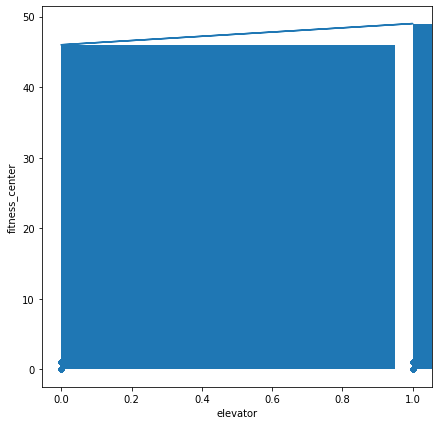

In [0]:
feature = 'elevator'
squared_errors(train, feature, target, m = 3, b = 46)